# Debugging Feature Initialization

In [1]:
import numpy as np
import torch

import pyro
import pyro.poutine as poutine
from pyro.contrib.tabular import TreeCat
from pyro.optim import Adam
from treecat_exp.preprocess import load_data, partition_data
from treecat_exp.util import TRAIN

np.set_printoptions(precision=4)
pyro.set_rng_seed(1)
pyro.get_param_store().clear()
pyro.enable_validation(True)

from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
# %config InlineBackend.figure_format = 'svg'

In [2]:
args = type("Args", (), {})
args.dataset = "housing"
args.max_num_rows = 9999999999
args.capacity = 32
args.init_size = 1024

Load data.

In [3]:
features, data, mask = load_data(args)
num_rows = len(data[0])
num_cells = num_rows * len(features)
print("loaded {} rows x {} features = {} cells".format(
      num_rows, len(features), num_cells))
print("\n".join(["Features:"] + [str(f) for f in features]))

loaded 506 rows x 14 features = 7084 cells
Features:
Real("CRIM")
Real("ZN")
Real("INDUS")
Boolean("CHAS")
Real("NOX")
Real("RM")
Real("AGE")
Real("DIS")
Real("RAD")
Real("TAX")
Real("PTRATIO")
Real("B")
Real("LSTAT")
Real("MEDV")


Initialize the model.

In [4]:
pyro.get_param_store().clear()
model = TreeCat(features, args.capacity)
trainer = model.trainer("map", optim=Adam({}))
for batch_data, batch_mask in partition_data(data, mask, args.init_size):
    break
trainer.init(batch_data, batch_mask)
model.guide(batch_data, batch_mask)  # initializes groups
print("\n".join("{} = {}".format(key, value.data.cpu().numpy())
                for key, value in sorted(pyro.get_param_store().items())))

auto_AGE_group_loc = [ 66.0737  26.2164  83.6047 110.0326  71.267   79.1278  65.3917  80.1435
  88.2837  39.8667  20.4563   5.1983  79.4305 104.8175  26.9328  87.8321
  95.1223  63.5667 103.272   34.1902 108.2488 107.1871  80.1494  90.9858
  59.4773  55.2732  72.4228  68.1023   6.5645  55.5187  88.4793  45.999 ]
auto_AGE_group_scale = [ 9.4712 17.7133 10.7413 13.2028 12.6732  5.0324  7.0382 11.1876 13.6835
  7.2714 13.9643 11.8972  9.6894 12.3937 17.8266 14.4458  8.1737  6.5079
 11.3363 10.0808  7.0481 10.1869  7.942   9.4333  7.5918 10.3687  9.8306
  8.6202 10.1604  8.8434  6.1769  8.2275]
auto_AGE_shared_loc_loc = 6.628700256347656
auto_AGE_shared_loc_scale = 7.389056205749512
auto_AGE_shared_scale_loc = 2.336517810821533
auto_AGE_shared_scale_scale = 1.0
auto_B_group_loc = [235.7536 369.376  333.3104 331.8585 348.6945 379.89   445.6995 362.2279
 358.1329 406.3594 323.4988 470.6469 448.8007 406.0574 485.3693 353.1433
 292.2549 278.4928 343.2257 387.9113 372.6407 381.4155 337.5462 268

In [5]:
@torch.no_grad()
def plot_feature(name):
    (f, col), = [(f, col) for f, col in zip(features, batch_data) if f.name == name]
    guide_trace = poutine.trace(model.guide).get_trace(batch_data, batch_mask)
    with poutine.replay(trace=guide_trace):
        shared = f.sample_shared()
        with pyro.plate("components", args.capacity):
            group = f.sample_group(shared)

    print("data mean = {:0.3g}, std = {:0.3g}".format(col.float().mean(),
                                                      col.float().std()))
    print("\n".join("{} = {}".format(key, value.data.cpu().numpy())
                    for key, value in sorted(pyro.get_param_store().items())
                    if key.startswith("auto_{}_".format(name))))

    pyplot.figure(figsize=(9, 8), dpi=300)
    pyplot.hist(col.numpy(), alpha=0.3, label='data', bins=20, density=True)
    datatype = type(f).__name__
    if datatype == "Real":
        x0 = col.min().item()
        x1 = col.max().item()
        X = torch.linspace(x0, x1, 100)
    elif datatype == "Discrete":
        X = torch.arange(f.cardinality)
    else:
        raise ValueError(type(f))
    for i in range(args.capacity):
        d = f.value_dist(group, i)
        Y = d.log_prob(X).exp().numpy()
        if datatype == "Real":
            pyplot.plot(X.numpy(), Y,
                        label='loc={:0.2g}, scale={:0.2g}'.format(d.loc, d.scale))
        else:
            pyplot.plot(X.numpy(), Y)
    pyplot.title(name)
    pyplot.legend(loc='best')
    pyplot.tight_layout()

data mean = 11.4, std = 23.3
auto_ZN_group_loc = [  8.7295 -14.4675  25.0775  36.0671  12.2907  16.8321   2.1482 -20.7237
  58.7257 -16.8073   8.876   48.6818  -8.6503   2.5883  26.8289  15.3522
  40.793  -16.7022   0.5017  -7.5263  30.031  -13.5333  14.2246   6.6498
 -14.9402  27.8275  17.705   20.6849  54.5079   1.543   32.2046  38.3194]
auto_ZN_group_scale = [11.1545  5.2273  9.8561 10.0975  8.3783  7.1008  8.0954  7.9834 10.7129
 10.1608  7.0194  8.7957  8.9835  8.2826 15.4327  6.0975  7.5888  5.0489
  8.0972 10.8743 23.0908 13.3358 10.8988 13.0544  6.5879 10.4678 12.2544
 15.3958 11.9261  9.5216  6.9708  7.3105]
auto_ZN_shared_loc_loc = 1.325766682624817
auto_ZN_shared_loc_scale = 7.389056205749512
auto_ZN_shared_scale_loc = 2.1484274864196777
auto_ZN_shared_scale_scale = 1.0


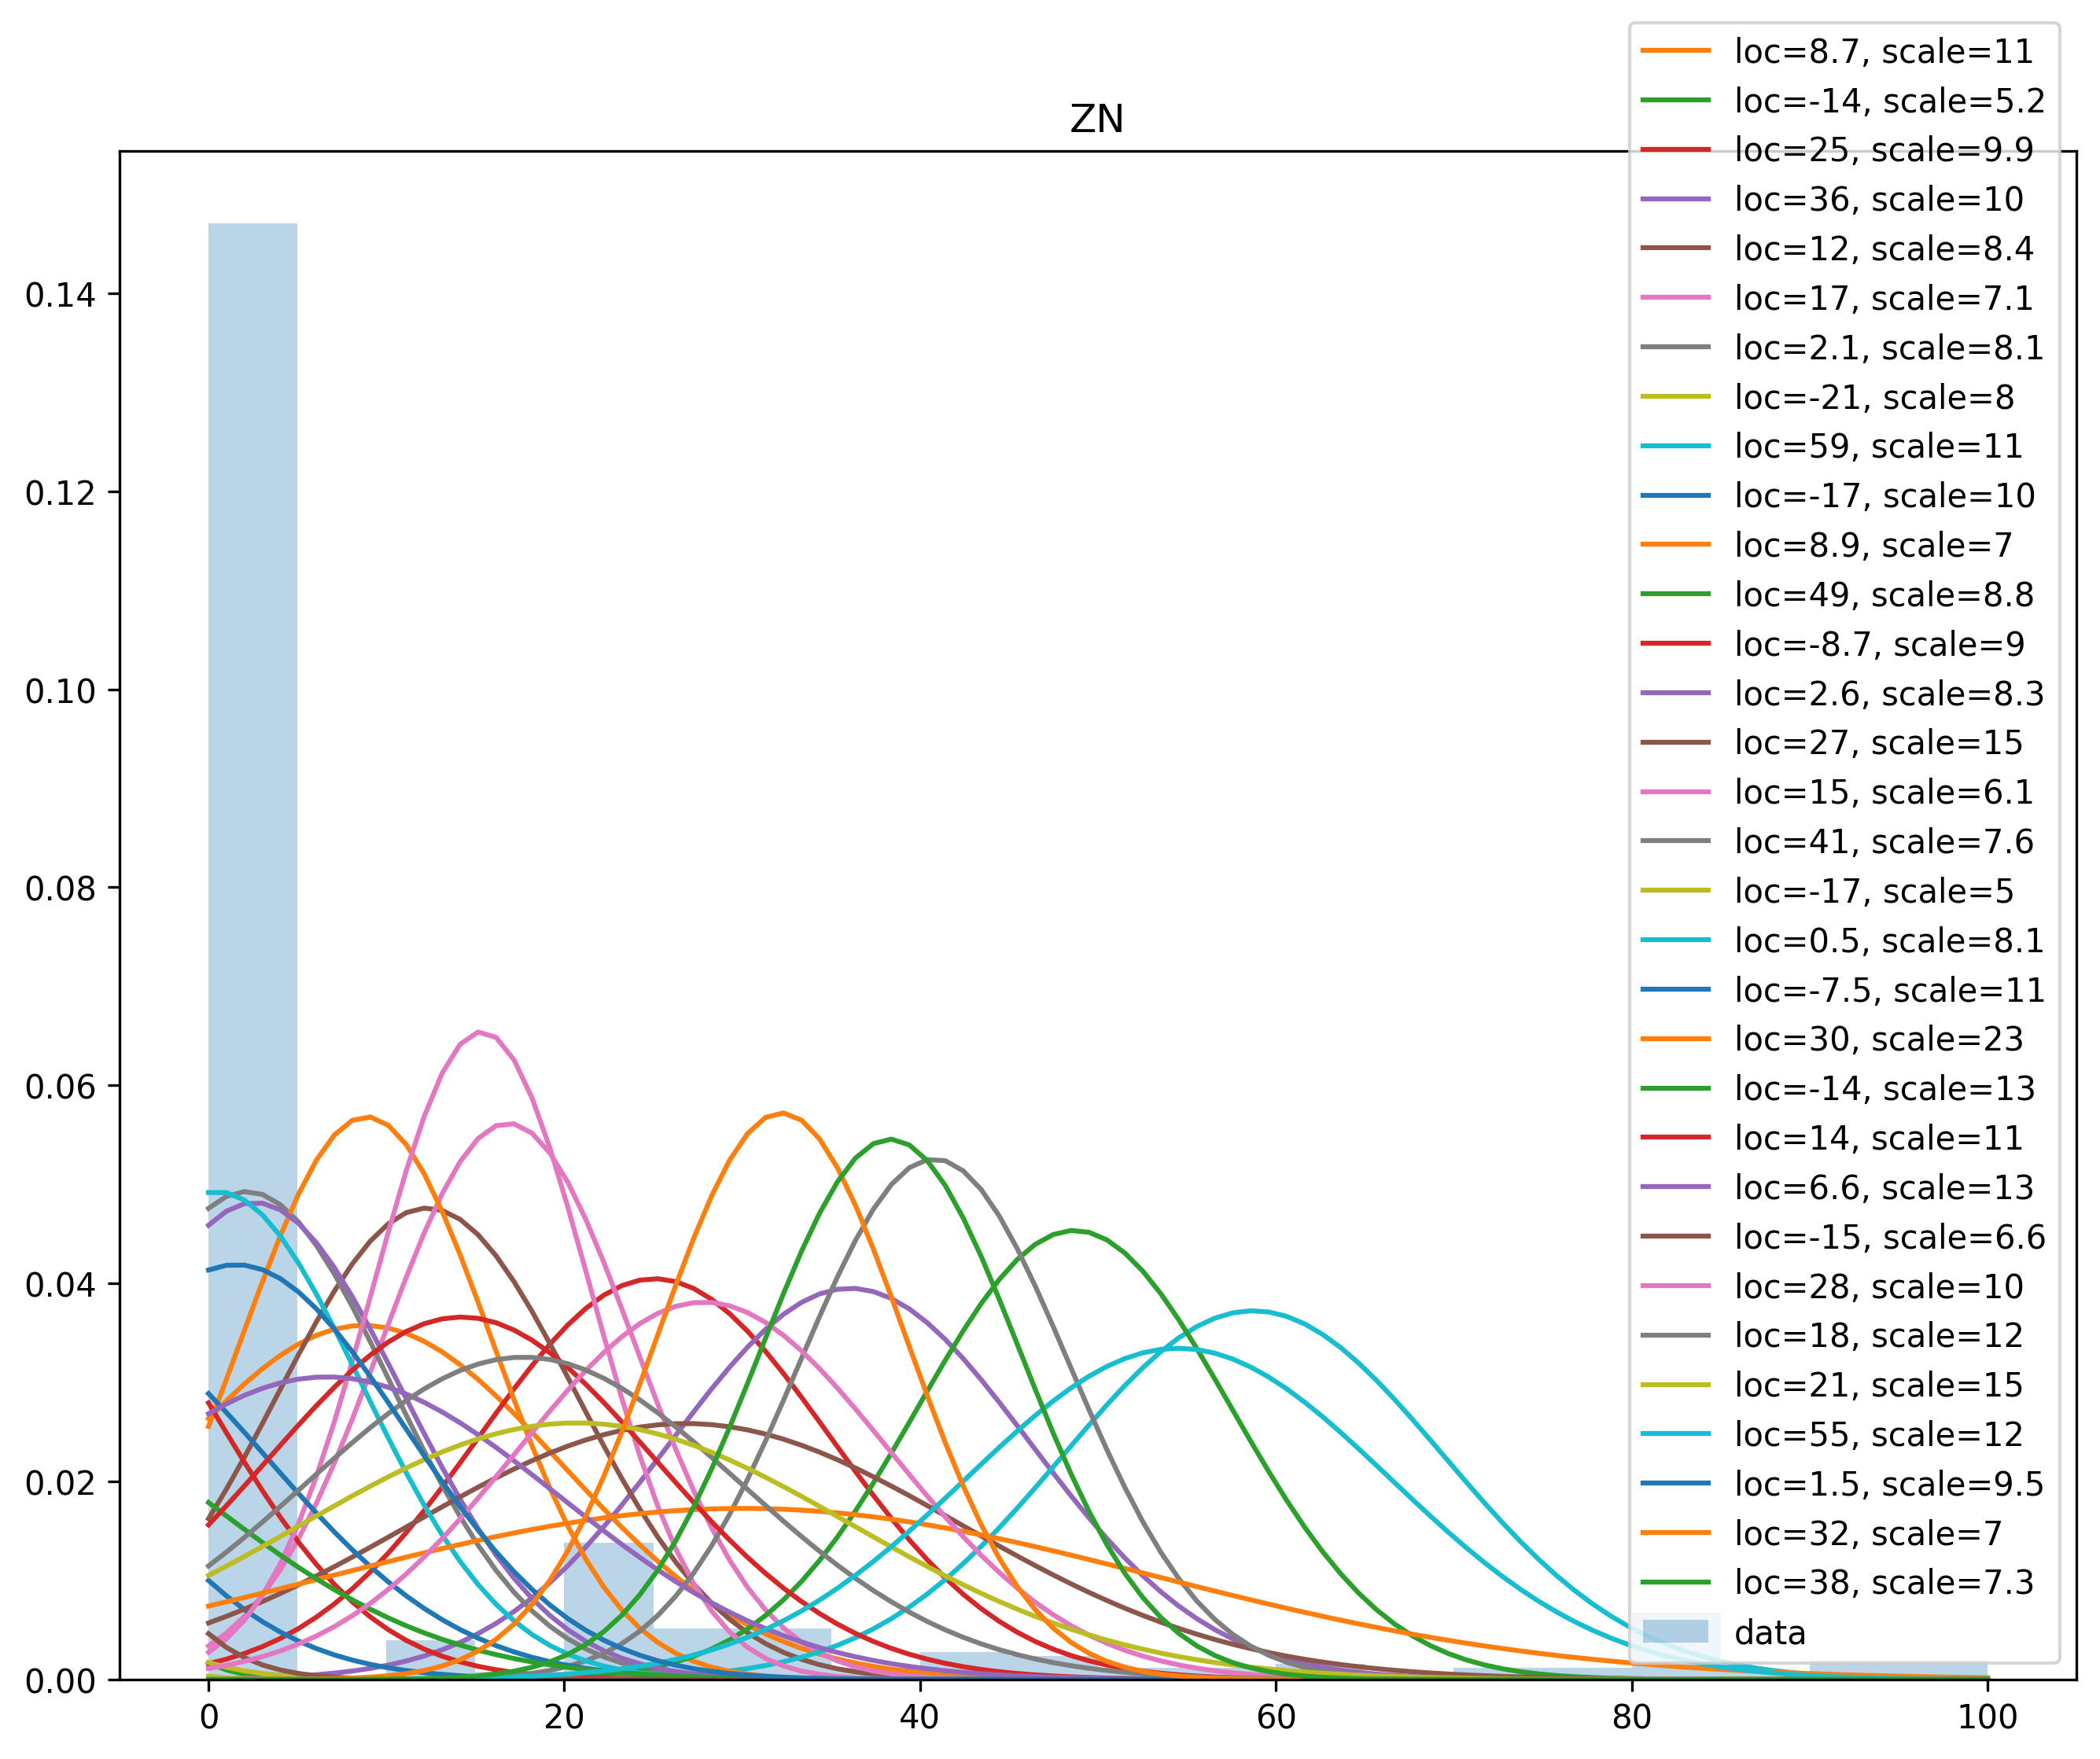

In [6]:
FEATURE = "ZN"
plot_feature(FEATURE)

Now load the trained model.

In [7]:
pyro.get_param_store().load("results/train/{}.treecatnuts.{}.model.pyro"
                            .format(args.dataset, args.capacity))

data mean = 11.4, std = 23.3
auto_ZN_group_loc = [-5.7876e+00  3.1181e+01  1.0607e+01  2.9411e+01  2.8389e+01  1.6105e+01
 -3.3941e+00  4.4732e+01  5.1330e+01  7.1634e+01  1.9300e+01  6.5991e+00
  2.4376e+01 -2.8658e+01  1.2126e+01  1.9780e+00  6.9923e+00  8.0263e+00
 -4.8464e+01  1.3087e+01 -1.5733e+01  3.3874e+01  9.6117e+00  3.6620e+01
  3.2531e+01 -1.2316e+00  2.1052e+00  2.8500e+01  5.7530e+00  2.0555e+01
 -8.3650e+00 -1.6803e-06]
auto_ZN_group_scale = [1.2800e+01 1.4236e+01 7.0124e+00 3.9587e+00 8.1294e+00 6.7346e+00
 9.4396e+00 8.8684e+00 5.6003e+00 3.2805e+01 5.7800e+00 5.5420e+00
 8.7124e+00 5.6950e+00 1.1214e+01 4.4251e+00 6.4574e+00 9.8282e+00
 1.0910e+01 1.7055e+01 1.1870e+01 6.4221e+00 8.6190e+00 5.8857e+00
 1.2832e+01 7.7786e+00 5.5715e+00 1.1404e+01 1.3494e+01 8.6608e+00
 1.0630e+01 1.8173e-04]
auto_ZN_shared_loc_loc = 1.0700350999832153
auto_ZN_shared_loc_scale = 3.010453462600708
auto_ZN_shared_scale_loc = 2.001999855041504
auto_ZN_shared_scale_scale = 1.07246351242065

(0.0001, 100.0)

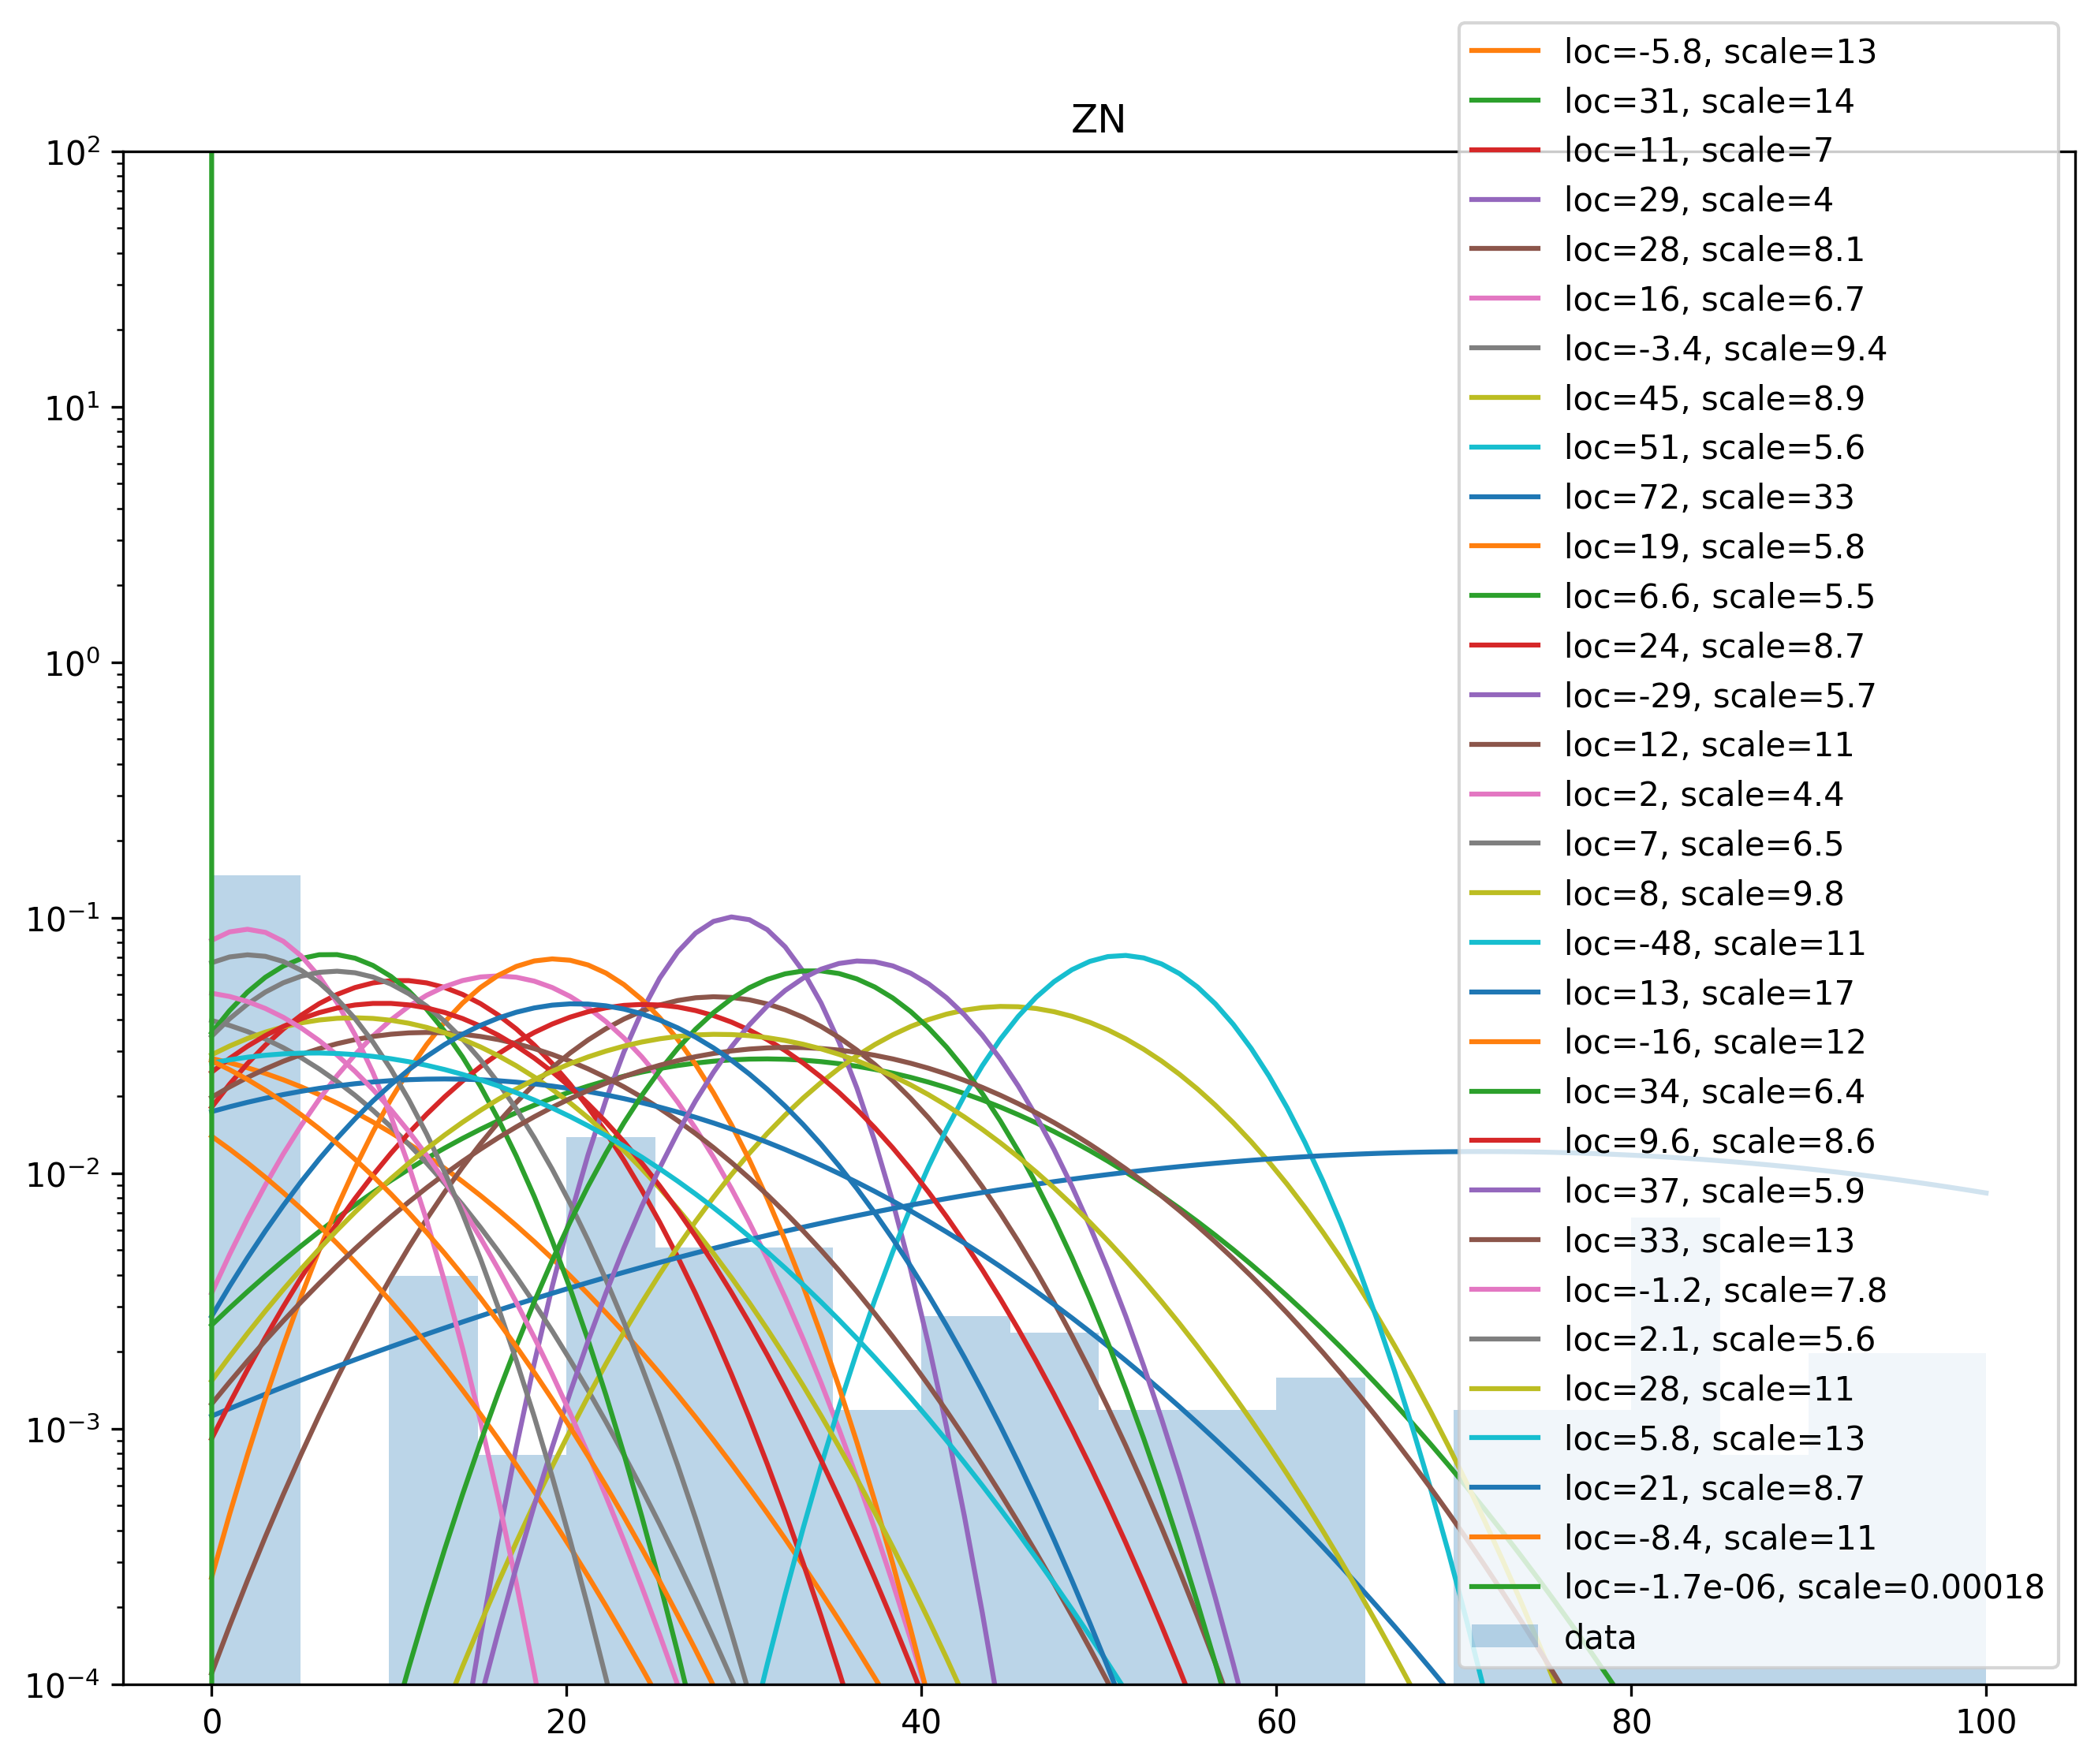

In [8]:
plot_feature(FEATURE)
pyplot.yscale('log')
pyplot.ylim(1e-4, 1e2)